### Changes camparing to DCGAN:
1. Cancel sigmoid function in discriminator
2. WGAN weight clipping-- clip discriminator weights between -0.01, 0.01
3. G_loss, D_loss change according to WGAN criteria
4. Change optimizer from Adam to RMSProp


paper: [Wasserstein GAN](https://arxiv.org/abs/1701.07875)

**However, this is a bad case-- need further adjust**

## 1. Import dataset & data preprocess

See details in utils/data_preprocess.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Example input images:


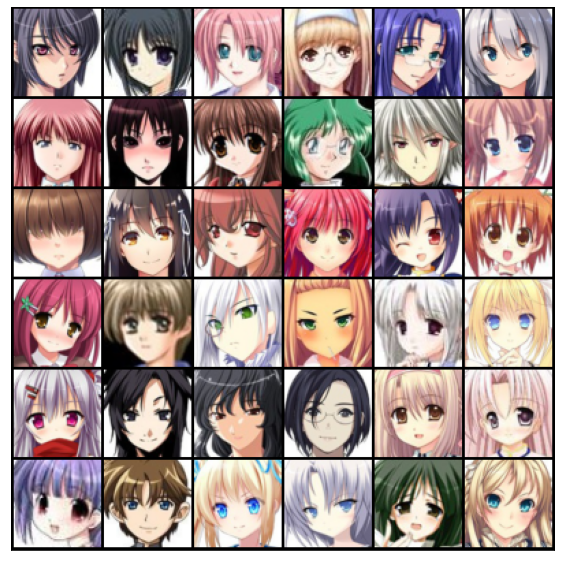

In [ ]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/data_preprocess.ipynb

## 2. Load DCGAN base architecture


In [ ]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Inputs for the run:
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3    # Number of channels in the training images. For color images this is 3
latent_size = 128  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
epochs = 20
lr = 0.0002
betas = (0.5, 0.999)
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1
            #512 = ngf * 8
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            #nn.Sigmoid()-- No sigmoid in WGAN network
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

torch.Size([128, 3, 64, 64])


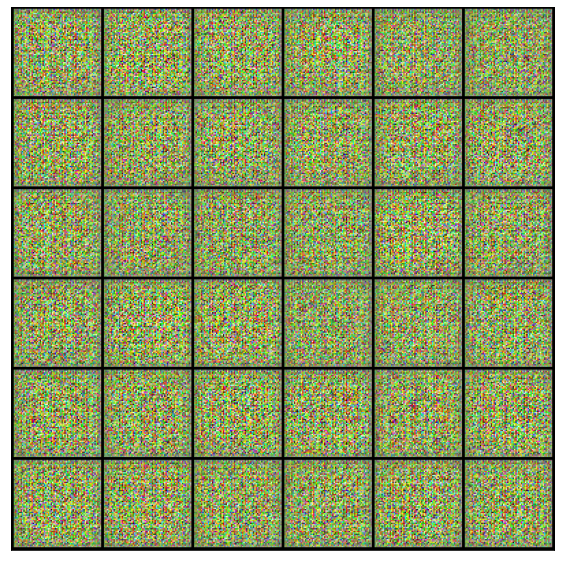

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [ ]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of generator:' + color.END)

print(summary(generator,(latent_size,1,1)))

Architecture of generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
            

In [ ]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of discriminator:' + color.END)
print(summary(discriminator,(3,64,64)))

Architecture of discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
        

## Train WGAN


In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.autograd import Variable

In [ ]:
sample_dir = 'generated_wgan/images'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


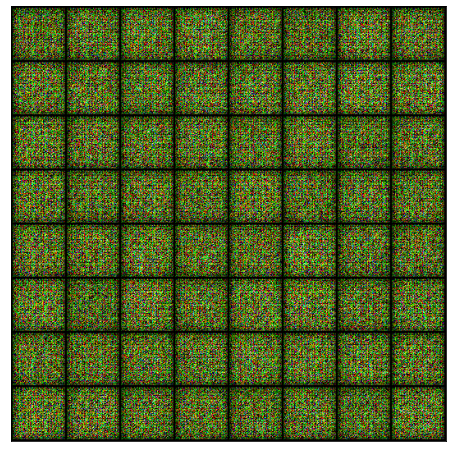

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

initialize_weights(discriminator)
initialize_weights(generator)


In [ ]:
generator = Generator()
discriminator = Discriminator()
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    
    # Create optimizers
    optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator
            # Clear discriminator gradients
            optimizer_D.zero_grad()

            # Pass real images through discriminator
            real_preds = discriminator(real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = discriminator(fake_images)

            # Update discriminator weights
            loss_d = -torch.mean(real_preds) + torch.mean(fake_preds)
            loss_d.backward()
            optimizer_D.step()
            loss_d = loss_d.item()

            #WGAN weight clipping-- clip weights between -0.01, 0.01
            for p in discriminator.parameters():
              p.data.clamp_(-0.01, 0.01)


            # Clear generator gradients
            optimizer_G.zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            
            # Try to fool the discriminator
            preds = discriminator(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = -torch.mean(fake_images)
            
            # Update generator weights
            loss_g.backward()
            optimizer_G.step()

            loss_g = loss_g.item()
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d

In [ ]:
history = fit(epochs, lr)

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
path = '/content/generated_wgan'

!cp -r '/content/generated_wgan' '/content/drive/MyDrive/ML_notes/301_Final_proj'

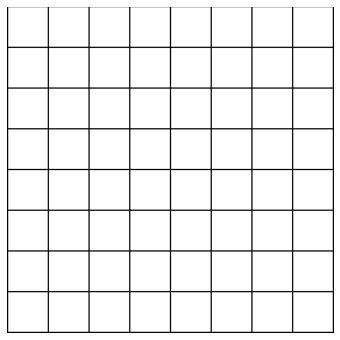

In [ ]:
output_dir = '/content/generated_wgan/images'
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/visualize_outputs.ipynb

In [ ]:
HTML(ani.to_jshtml())